# Female discrimination analysis using DAGs

[Reference](https://mixtape.scunning.com/03-directed_acyclical_graphs#discrimination-and-collider-bias)

## Dependencies

In [2]:
%pip install stargazer

Note: you may need to restart the kernel to use updated packages.


## Syntetic data generation

The syntetic data hard-codes the data represented by the previous DAG:
$$Wage = 1 - Discrimination + Occupation + 2 \cdot Ability \quad \text{(1)}$$
$$Occupation = 1 - 2 \cdot Discrimination + 2 \cdot Ability \quad \text{(2)}$$
$$Discrimination = 1 \cdot Female \quad \text{(3)}$$

What the data is effectively modeling:
- Occupations are increasing in unobserved ability but decreasing in discrimination.
- Wages are decreasing in discrimination but increasing in higher-quality jobs and higher ability.
- Discrimination exists in the simulation because it's being hardcoded with negative coefficients for both occupation and wage.

Note: the **ability** is randomly generated since it has no relationship to being female.

The goal of the analysis is to go from the *somewhat random data* back to the "actual" linear coefficients above by fitting linear regressors on different combinations of the features. The "actual" coefficients emulate a real-world discrimination setup caused by the gender condition. So we want to model the most accurate $\beta_{F}$ linear coefficient against the actual coefficient `-1` from eq (1).

In [3]:
import numpy as np 
import pandas as pd


# Generate the syntetic data
np.random.seed(42)
size = 10000 # Total data size
df = pd.DataFrame({
    "female": np.random.binomial(1, .5, size=size),
})

# The ability is independent of female preferences
df["ability"] = np.random.normal(size=size)

# Being female is directly associated to being discriminated
df["discrimination"] = df["female"]

# Occupation:
# The 'ability' influences positively the occupation
# The 'discrimination' influences negatively the occupation
# + random error
df["occupation"] = 1 + 2 * df["ability"] - 2 * df["discrimination"] + np.random.normal(size=size)

# Wage (Y):
# The 'discrimination' influences negatively the wages
# The 'ocupation' and 'ability' influence positively
# + random error
df["wage"] = 1 - df["discrimination"] + df["occupation"] + 2 * df["ability"] + np.random.normal(size=size)

df.head()

,female,ability,discrimination,occupation,wage
0,0,-1.487862,0,-2.591872,-3.783913
1,1,-1.125186,1,-3.643047,-5.885880
2,1,0.388819,1,-1.254189,0.178262
3,1,-1.173873,1,-4.236999,-7.599063
4,0,1.112634,0,3.659646,7.028300


## The graph representation of the defined relationships

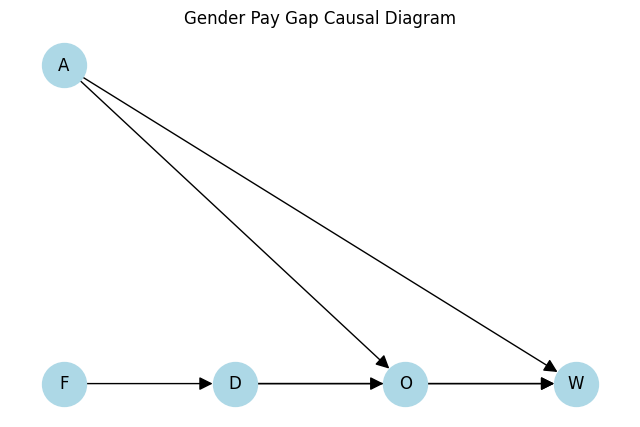

In [4]:
import networkx as nx
import matplotlib.pyplot as plt


# Define the DAG structure (using an edge list)
G = nx.DiGraph([
    ("F", "D"), # Female -> Discrimination
    ("D", "O"), # Discrimination -> Occupation
    ("D", "W"), # Discrimination -> Wage
    ("O", "W"), # Occupation -> Wage
    ("A", "O"), # Ability -> Occupation
    ("A", "W"), # Ability -> Wage
])

pos = {}
for layer, nodes in enumerate(nx.topological_generations(G)):
    # Distribute nodes within each layer
    for i, node in enumerate(nodes):
        pos[node] = (layer, i * 2) # Adjust spacing as needed
        

plt.figure(figsize=(8, 5)) # Set the figure size
nx.draw_networkx(G, 
                 pos=pos, 
                 with_labels=True, 
                 node_color="lightblue", 
                 node_size=1000, 
                 arrowsize=20, 
                 font_size=12)

plt.title("Gender Pay Gap Causal Diagram")
plt.axis("off") # Hide the axis
plt.show()

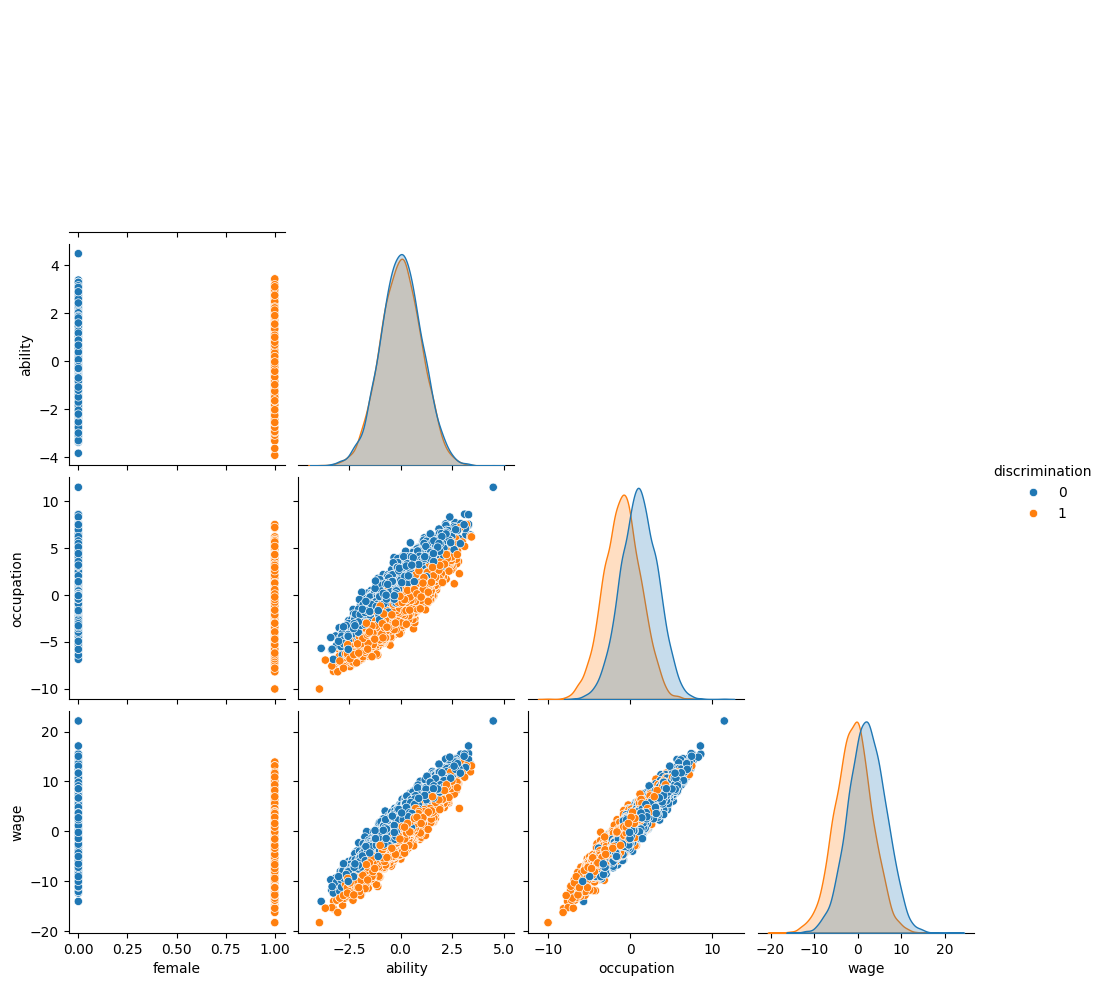

In [5]:
import seaborn as sns


sns.pairplot(
    df, 
    corner=True,
    hue="discrimination",
);

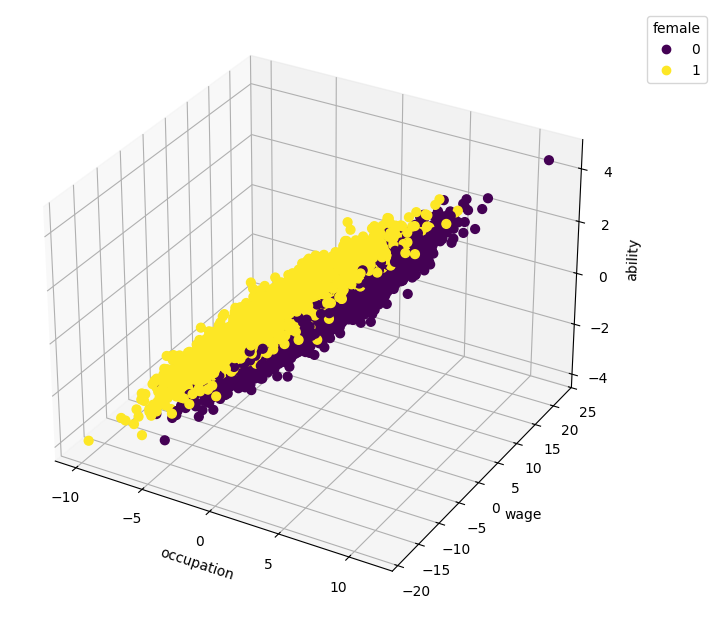

In [6]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

sc = ax.scatter(
    xs=df["occupation"],
    ys=df["wage"],
    zs=df["ability"],
    s=40, 
    c=df["female"], 
    marker="o",
    alpha=1
)

ax.set_xlabel('occupation')
ax.set_ylabel('wage')
ax.set_zlabel('ability')

# legend
plt.legend(
    *sc.legend_elements(), 
    bbox_to_anchor=(1.05, 1), 
    loc=2,
    title="female",
)
plt.show()

## Linear models

### Model 1: Biased Uncontrolled
**The model:** `wage ~ female` (Regression of wages on *gender only*, with *no other variables*).

**Why 'Unconrolled':** It does not "control" on any other variables like occupation or ability.

**Why "Biased":** In this specific simulation, being female affects wages in two ways:
- **Directly** (direct discrimination).
- **Indirectly** (by affecting which occupations women enter).The goal of the exercise is to find the direct effect (hard-coded as $-1$).

**Occupation** is a *collider variable* because it is caused by both **discrimination** and **unobserved ability** `(Discrimination -> Occupation <- Ability)`.

In [7]:
from IPython.display import display, Math
import statsmodels.api as sm


# Equation 1
eq_1 = Math(r'W = \beta_0 + \beta_{F} \cdot F + \epsilon')
display(eq_1)
# Model 1
lm_1 = sm.OLS.from_formula("wage ~ female", data=df).fit()

<IPython.core.display.Math object>

### Model 2: Biased controlled
**The model:** `wage ~ female + occupation` (regression controlled for the occupation)

**The logic:** When you control for a collider, you "open up" a spurious (fake) correlation between its causes. By *conditioning* on **occupation**, the model creates a false link between gender and ability. This bias is so strong that the coefficient for female actually flips from negative to positive (showing women being "favored"), even though we know the true effect is negative. This is why it is simply labeled "Biased"—it represents the trap researchers fall into when they control for "everything" without a DAG.


In [8]:
eq_2 = Math(r'W = \beta_0 + \beta_{F} \cdot F + \beta_{O} \cdot O + \epsilon')
display(eq_2)
# Model 1
lm_2 = sm.OLS.from_formula("wage ~ female + occupation", data=df).fit()

<IPython.core.display.Math object>

### ✅ Model 3: Unbiased Controlled
**The model:** `wage ~ female + occupation + ability`

**The logic:** By including Ability in the regression, you "close" the spurious path that was opened in the previous model. This allows the regression to correctly isolate the direct effect of being female on wages. In the simulation, this model returns a coefficient of approximately $-1$, which matches the "true" discrimination value hard-coded into the data-generating process.

In [9]:
# Model 3
eq_3 = Math(r'W = \beta_0 + \beta_{F} \cdot F + \beta_{O} \cdot O + \beta_{A} \cdot A + \epsilon')
display(eq_3)
lm_3 = sm.OLS.from_formula("wage ~ female + occupation + ability", data=df).fit()

<IPython.core.display.Math object>

### Checking the results

In [10]:
from stargazer.stargazer import Stargazer


# Comparing the regressors
st = Stargazer((lm_1, lm_2, lm_3,))
st.custom_columns([
    "W ~ F", 
    "W ~ F + O", 
    "W ~ F + O + A",
])
st